In [1]:
from dgl.data import MovieLensDataset

import torch
import numpy as np
import matplotlib.pyplot as plt
import dgl
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neighbors import kneighbors_graph
import pandas as pd

import time
import yaml

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
assert torch.cuda.is_available()

In [3]:
def get_timestamp():
    return time.strftime("%Y%m%d-%H%M%S")

# Data preparation

In [4]:
dataset = MovieLensDataset(name="ml-100k", valid_ratio=0.1, test_ratio=0.1)

/home/vtenorio/.local/lib/python3.12/site-packages/dgl/data/movielens.py:201: DGLWarning: test_ratio (0.1) is not set to None for ml-100k. Note that dataset split would not be affected by the test_ratio since testing samples of ml-100k have been pre-specified.
  dgl_warning(


In [5]:
g = dataset[0]
g

Graph(num_nodes={'movie': 1682, 'user': 943},
      num_edges={('movie', 'movie-user', 'user'): 100000, ('user', 'user-movie', 'movie'): 100000},
      metagraph=[('movie', 'user', 'movie-user'), ('user', 'movie', 'user-movie')])

In [6]:
Nu = g.num_nodes(ntype='user')
Ni = g.num_nodes(ntype='movie')
Ne = g.num_edges(etype='user-movie')
Nu, Ni, Ne

(943, 1682, 100000)

In [7]:
rate = g.edges['user-movie'].data['rate']
mean_rate = rate.mean()
rate_norm = rate.float() - mean_rate
mean_rate
#rate_norm = rate_norm / rate_norm.std()

tensor(3.5299)

In [8]:
user_movie_edges = g.edges(etype='user-movie')
user_movie_edges[0].max(), user_movie_edges[1].max()

(tensor(942), tensor(1681))

In [9]:
train_mask = g.edges['user-movie'].data['train_mask']
val_mask = g.edges['user-movie'].data['valid_mask']
test_mask = g.edges['user-movie'].data['test_mask']
assert train_mask.sum() + val_mask.sum() + test_mask.sum() == Ne
assert train_mask.shape[0] == val_mask.shape[0] == test_mask.shape[0] == Ne

In [10]:
train_mask.sum() + val_mask.sum() + test_mask.sum()

tensor(100000)

In [11]:
train_ratings = rate[train_mask]
val_ratings = rate[val_mask]
test_ratings = rate[test_mask]

In [12]:
train_mask_mat = torch.zeros(Nu, Ni, dtype=torch.bool)
val_mask_mat = torch.zeros(Nu, Ni, dtype=torch.bool)
test_mask_mat = torch.zeros(Nu, Ni, dtype=torch.bool)

rate_mat = torch.zeros(Nu, Ni)
for j in range(Ne):
    u, i = user_movie_edges[0][j], user_movie_edges[1][j]
    rate_mat[u, i] = rate_norm[j]
    train_mask_mat[u, i] = train_mask[j]
    val_mask_mat[u, i] = val_mask[j]
    test_mask_mat[u, i] = test_mask[j]
train_mask_mat.sum(), val_mask_mat.sum(), test_mask_mat.sum()

(tensor(72000), tensor(8000), tensor(20000))

In [13]:
user_movie_edges

(tensor([129,  59, 449,  ..., 458, 459, 461]),
 tensor([793, 433, 714,  ..., 933,   9, 681]))

In [14]:
train_idx = [(user_movie_edges[0][j].item(), user_movie_edges[1][j].item()) for j in range(Ne) if train_mask[j]]
val_idx = [(user_movie_edges[0][j].item(), user_movie_edges[1][j].item()) for j in range(Ne) if val_mask[j]]
test_idx = [(user_movie_edges[0][j].item(), user_movie_edges[1][j].item()) for j in range(Ne) if test_mask[j]]

In [15]:
feat_type = "ratings" # "data" "ratings"
if feat_type == "ratings":
    # Use ratings as features
    X = rate_mat.clone().float()
    Y = rate_mat.T.clone().float()
    X[~train_mask_mat] = 0.
    Y[~train_mask_mat.T] = 0.
elif feat_type == "data":
    X = g.nodes["user"].data["feat"]
    Y = g.nodes["movie"].data["feat"]
X.shape, Y.shape

(torch.Size([943, 1682]), torch.Size([1682, 943]))

In [16]:
def build_graphs(adj_type: str, gmethod: str, nneigh: int=-1, weighted: bool=False, pct_conn: float=-1.):
    if adj_type == "rating_sim":
        user_feat = rate_mat.clone()
        item_feat = rate_mat.T.clone()
    elif adj_type == "feat_sim":
        user_feat = X.clone()
        item_feat = Y.clone()

    if gmethod == "kneighbors":
        assert nneigh > 0
        user_adj = kneighbors_graph(user_feat.cpu().numpy(), nneigh, mode='distance' if weighted else 'connectivity', include_self=False)
        user_adj = torch.tensor(user_adj.toarray()).float()

        item_adj = kneighbors_graph(item_feat.cpu().numpy(), nneigh, mode='distance' if weighted else 'connectivity', include_self=False)
        item_adj = torch.tensor(item_adj.toarray()).float()
    else:
        assert pct_conn > 0
        user_dists = torch.cdist(user_feat, user_feat, p=2)
        item_dists = torch.cdist(item_feat, item_feat, p=2)

        th_user = user_dists.flatten().topk(int(Nu**2 * pct_conn), largest=False)[0][-1]
        user_adj = (user_dists <= th_user).float()
        user_adj = user_adj - torch.eye(Nu, device=user_adj.device)

        th_item = item_dists.flatten().topk(int(Ni**2 * pct_conn), largest=False)[0][-1]
        item_adj = (item_dists <= th_item).float()
        item_adj = item_adj - torch.eye(Ni, device=user_adj.device)

    user_edge_idx = torch.nonzero(user_adj, as_tuple=False).T
    item_edge_idx = torch.nonzero(item_adj, as_tuple=False).T

    guser = dgl.graph((user_edge_idx[0], user_edge_idx[1]), num_nodes=Nu, idtype=torch.int32)
    gitem = dgl.graph((item_edge_idx[0], item_edge_idx[1]), num_nodes=Ni, idtype=torch.int32)

    return user_adj, item_adj, guser, gitem

# Classes

In [17]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers, nonlin):
        super().__init__()

        self.n_layers = n_layers
        if nonlin == "relu":
            self.nonlin = nn.ReLU()
        elif nonlin == "tanh":
            self.nonlin = nn.Tanh()
        self.convs = nn.ModuleList()

        if n_layers > 1:
            self.convs.append(dgl.nn.GraphConv(in_dim, hid_dim, norm='both'))
            for i in range(n_layers - 2):
                self.convs.append(dgl.nn.GraphConv(hid_dim, hid_dim, norm='both'))
            self.convs.append(dgl.nn.GraphConv(hid_dim, out_dim, norm='both'))
        else:
            self.convs.append(dgl.nn.GraphConv(in_dim, out_dim, norm='both'))

    def forward(self, graph, x):

        for i in range(self.n_layers - 1):
            x = self.nonlin(self.convs[i](graph, x))
        x = self.convs[-1](graph, x)

        return x

class GAT(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers, nonlin, num_heads, feat_drop, attn_drop):
        super().__init__()

        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.num_heads = num_heads
        self.feat_drop = feat_drop
        self.attn_drop = attn_drop
        if nonlin == "relu":
            self.nonlin = nn.ReLU()
        elif nonlin == "tanh":
            self.nonlin = nn.Tanh()
        self.convs = nn.ModuleList()
        
        if self.n_layers > 1:
            self.convs.append(dgl.nn.GATConv(self.in_dim, self.hid_dim, self.num_heads))
            for i in range(self.n_layers - 2):
                self.convs.append(dgl.nn.GATConv(self.hid_dim*self.num_heads, self.hid_dim, self.num_heads))
            self.convs.append(dgl.nn.GATConv(self.hid_dim*self.num_heads, self.out_dim, 1))
        else:
            self.convs.append(dgl.nn.GATConv(self.in_dim, self.out_dim, 1))
    
    def forward(self, graph, x):
        if x.ndim == 3:
            x = x.permute(1,0,2)
            x_shape = (x.shape[0], x.shape[1], -1)
        else:
            x_shape = (x.shape[0], -1)

        for i in range(self.n_layers - 1):
            x = self.nonlin(self.convs[i](graph, x)).reshape(x_shape)
        x = self.convs[-1](graph, x).reshape(x_shape)

        if x.ndim == 3:
            return x.permute(1,0,2)
        else:
            return x

class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers, nonlin="relu"):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        if nonlin == "relu":
            self.nonlin = nn.ReLU()
        elif nonlin == "tanh":
            self.nonlin = nn.Tanh()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(in_dim, hid_dim))

        if n_layers > 1:
            self.layers.append(nn.Linear(in_dim, hid_dim))
            for i in range(n_layers - 2):
                self.layers.append(nn.Linear(hid_dim, hid_dim))
            self.layers.append(nn.Linear(hid_dim, out_dim))
        else:
            self.layers.append(nn.Linear(in_dim, out_dim))

    def forward(self, graph, x): # Graph kept for compatibility with GCN

        for i in range(self.n_layers - 1):
            x = self.nonlin(self.layers[i](x))
        x = self.layers[-1](x)

        return x

In [18]:
class GCNHLayer(nn.Module):
    def __init__(self, S, in_dim, out_dim, K):
        super().__init__()

        self.S = S
        self.N = self.S.shape[0]
        self.S += torch.eye(self.N, device=self.S.device)
        self.d = self.S.sum(1)
        self.D_inv = torch.diag(1 / torch.sqrt(self.d))
        self.S = self.D_inv @ self.S @ self.D_inv

        self.K = K
        self.Spow = torch.zeros((self.K, self.N, self.N), device=self.S.device)
        self.Spow[0,:,:] = torch.eye(self.N, device=self.S.device)
        for k in range(1, self.K):
            self.Spow[k,:,:] = self.Spow[k-1,:,:] @ self.S

        self.Spow = nn.Parameter(self.Spow, requires_grad=False)

        self.S = nn.Parameter(self.S, requires_grad=False)

        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.W = nn.Parameter(torch.empty(self.K, self.in_dim, self.out_dim))
        nn.init.kaiming_uniform_(self.W.data)

        self.bias = nn.Parameter(torch.zeros(self.out_dim))
        nn.init.zeros_(self.bias.data)

    def forward(self, x):
        assert (self.N, self.in_dim) == x.shape
        out = torch.zeros((self.N, self.out_dim), device=x.device)
        for k in range(self.K):
            out += self.Spow[k,:,:] @ x @ self.W[k,:,:]
        return out + self.bias[None,:]

class GCNH(nn.Module):
    def __init__(self, S, in_dim, hid_dim, out_dim, K, n_layers, nonlin="relu"):
        super().__init__()

        self.n_layers = n_layers
        if nonlin == "relu":
            self.nonlin = nn.ReLU()
        elif nonlin == "tanh":
            self.nonlin = nn.Tanh()
        self.convs = nn.ModuleList()

        if n_layers > 1:
            self.convs.append(GCNHLayer(S, in_dim, hid_dim, K))
            for i in range(n_layers - 2):
                self.convs.append(GCNHLayer(S, hid_dim, hid_dim, K))
            self.convs.append(GCNHLayer(S, hid_dim, out_dim, K))
        else:
            self.convs.append(GCNHLayer(S, in_dim, out_dim, K))


    def forward(self, graph, x):

        for i in range(self.n_layers - 1):
            x = self.nonlin(self.convs[i](x))
        x = self.convs[-1](x)

        return x

In [19]:
class IOArch(nn.Module):
    def __init__(self, in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin):
        super().__init__()
        self.in_dim_x = in_dim_x
        self.in_dim_y = in_dim_y
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.Nx = Nx
        self.Ny = Ny
        
    def forward(self, graph1, graph2, feat_x, feat_y):
        assert feat_x.shape[0] == self.Nx
        Zx = self.arch_X(graph1, feat_x)
        Zy = self.arch_Y(graph2, feat_y)

        assert Zx.shape[1] == Zy.shape[1] == self.out_dim

        return Zx, Zy
    
    def get_embeddings(self, graph1, graph2, feat_x, feat_y):
        Zx = self.arch_X(graph1, feat_x)
        Zy = self.arch_Y(graph2, feat_y)
        return Zx.detach(), Zy.detach()
    
    def get_ratings(self, graph1, graph2, feat_x, feat_y):
        Zx, Zy = self.get_embeddings(graph1, graph2, feat_x, feat_y)
        return Zx @ Zy.T

class IOGCN(IOArch):
    def __init__(self, in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin):
        super().__init__(in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin)

        self.arch_X = GCN(in_dim_x, hid_dim, out_dim, n_layers, nonlin)
        self.arch_Y = GCN(in_dim_y, hid_dim, out_dim, n_layers, nonlin)

class IOGAT(IOArch):
    def __init__(self, in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin, num_heads, feat_drop, attn_drop):
        super().__init__(in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin)

        self.arch_X = GAT(in_dim_x, hid_dim, out_dim, n_layers, nonlin, num_heads, feat_drop, attn_drop)
        self.arch_Y = GAT(in_dim_y, hid_dim, out_dim, n_layers, nonlin, num_heads, feat_drop, attn_drop)

class IOGCNH(IOArch):
    def __init__(self, Sx, Sy, in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin, K):
        super().__init__(in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin)

        self.arch_X = GCNH(Sx, in_dim_x, hid_dim, out_dim, K, n_layers, nonlin)
        self.arch_Y = GCNH(Sy, in_dim_y, hid_dim, out_dim, K, n_layers, nonlin)

class IOMLP(IOArch):
    def __init__(self, in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin):
        super().__init__(in_dim_x, in_dim_y, hid_dim, out_dim, Nx, Ny, n_layers, nonlin)

        self.arch_X = MLP(in_dim_x, hid_dim, out_dim, n_layers, nonlin)
        self.arch_Y = MLP(in_dim_y, hid_dim, out_dim, n_layers, nonlin)


# Training methods

In [20]:
def test(model, guser, gitem, X, Y, rate_mat,
         train_idx, val_idx, test_idx,
         n_epochs, patience_es, lr, wd, eval_freq, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    min_val_loss = float("inf")
    best_model = model.state_dict()
    patience = 0

    t_start = time.time()
    t_max = 24 * 60 * 60

    losses = np.zeros(n_epochs)
    for i in range(n_epochs):
        model.train()
        opt.zero_grad()

        Zx, Zy = model(guser, gitem, X, Y)
        est_ratings = Zx @ Zy.T

        loss = F.mse_loss(est_ratings[train_idx], rate_mat[train_idx])
        losses[i] = loss.item()

        loss.backward()
        opt.step()

        with torch.no_grad():
            model.eval()
            Zx, Zy = model(guser, gitem, X, Y)
            est_ratings = Zx @ Zy.T
            val_loss = F.mse_loss(est_ratings[val_idx], rate_mat[val_idx])
            test_loss = F.mse_loss(est_ratings[test_idx], rate_mat[test_idx])

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = model.state_dict()
            best_epoch = i
        else:
            patience += 1
            if patience > patience_es:
                if verbose:
                    print(f"Early stopping at epoch {i + 1}")
                break

        if time.time() - t_start > t_max:
            if verbose:
                print(f"Stopping training due to timeout {i + 1}")
            break

        if (i + 1) % eval_freq == 0 and verbose:
            print(f"Epoch {i + 1}/{n_epochs} - Train Loss: {loss.item()}, Validation Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    model.load_state_dict(best_model)
    with torch.no_grad():
        model.eval()
        Zx, Zy = model(guser, gitem, X, Y)
        est_ratings = Zx @ Zy.T
        test_loss = torch.mean((est_ratings[test_idx] - rate_mat[test_idx]) ** 2)
    return model, test_loss.item()

In [21]:
def low_rank_matrix_completion(
    rate, rank,
    train_idx, val_idx, test_idx,
    lr=0.01, epochs=1000, patience=10, verbose=True
    ):

    """
    Low-rank matrix completion using gradient descent.

    Args:
        rate (torch.Tensor): A tensor of shape (Nu,Ni) containing the ratings.
        rank (int): The rank for the low-rank approximation.
        train_idx (torch.Tensor): Boolean tensor for training edges.
        val_idx (torch.Tensor): Boolean tensor for validation edges.
        test_idx (torch.Tensor): Boolean tensor for test edges.
        lr (float): Learning rate for gradient descent.
        epochs (int): Number of training epochs.
        patience (int): Patience for early stopping.
        verbose (bool): If True, print training progress.

    Returns:
        torch.Tensor: The completed Nu x Ni matrix.
        float: The test loss (MSE) for the best model.
    """
    train_ratings = rate[train_idx]
    val_ratings = rate[val_idx]
    test_ratings = rate[test_idx]

    Nu, Ni = rate.shape

    # Initialize low-rank matrices U and V
    U = torch.randn(Nu, rank, requires_grad=True, device=device)
    V = torch.randn(Ni, rank, requires_grad=True, device=device)

    # Define optimizer
    optimizer = torch.optim.Adam([U, V], lr=lr)

    # Early stopping variables
    best_loss = float("inf")
    best_U, best_V = None, None
    patience_counter = 0

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute predicted ratings for known entries
        est_ratings = U @ V.T

        # Compute loss (mean squared error for known entries)
        loss = torch.mean((est_ratings[train_idx] - train_ratings) ** 2)

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        # Validation loss
        with torch.no_grad():
            loss_val = torch.mean((est_ratings[val_idx] - val_ratings) ** 2)

            # Early stopping logic
            if loss_val.item() < best_loss:
                best_loss = loss_val.item()
                best_U, best_V = U.clone().detach(), V.clone().detach()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter > patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch + 1}")
                    break

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0 and verbose:
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {loss.item()}, Val Loss: {loss_val.item()}")

    # Reconstruct the full matrix using the best U and V
    completed_matrix = best_U @ best_V.T
    test_loss = torch.mean((completed_matrix[test_idx] - test_ratings) ** 2)
    return completed_matrix, test_loss.item()

In [22]:
def nuclear_norm_matrix_completion(
        rate,
        train_idx, val_idx, test_idx,
        lr=0.01, epochs=1000, patience=10, verbose=True
    ):
    """
    Low-rank matrix completion using nuclear norm minimization.

    Args:
        rate (torch.Tensor): A tensor of shape (Nu,Ni) containing the ratings.
        train_idx (torch.Tensor): Boolean tensor for training edges.
        val_idx (torch.Tensor): Boolean tensor for validation edges.
        test_idx (torch.Tensor): Boolean tensor for test edges.
        lr (float): Learning rate for gradient descent.
        epochs (int): Number of training epochs.
        patience (int): Patience for early stopping.
        verbose (bool): If True, print training progress.

    Returns:
        torch.Tensor: The completed Nu x Ni matrix.
        float: The test loss (MSE) for the best model.
    """
    train_ratings = rate[train_idx]
    val_ratings = rate[val_idx]
    test_ratings = rate[test_idx]

    Nu, Ni = rate.shape
    
    # Initialize the matrix with zeros
    M = torch.randn(Nu, Ni, requires_grad=True, device=device)

    # Define optimizer
    optimizer = torch.optim.Adam([M], lr=lr)

    # Early stopping variables
    best_loss = float("inf")
    best_matrix = None
    patience_counter = 0
    t_start = time.time()
    t_max = 24*60*60 # 1 day in seconds

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute the nuclear norm of the matrix
        # U, S, V = torch.svd(M)  # Singular Value Decomposition
        # loss = S.sum() # Nuclear norm as sum of singular values
        loss = torch.norm(M, p='nuc')

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        # Fix the known values
        with torch.no_grad():
            M[train_idx] = train_ratings

            predicted_val_ratings = M[val_idx]

            # Compute the validation loss (MSE)
            loss_val = torch.mean((predicted_val_ratings - val_ratings) ** 2)

            # Early stopping logic
            if loss_val.item() < best_loss:
                best_loss = loss_val.item()
                best_matrix = M.clone().detach()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter > patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch + 1}")
                    break

            if time.time() - t_start > t_max:
                if verbose:
                    print(f"Stopping training due to timeout {epoch + 1}")
                break

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0 and verbose:
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {loss.item()}, Val Loss: {loss_val.item()}")

    M = best_matrix
    test_loss = torch.mean((M[test_idx] - test_ratings) ** 2)
    return M, test_loss.item()

# Model and Tests

In [23]:
lr = 1e-4
wd = 1e-5
n_epochs = 10000
patience_es = 1000

in_dim_x = X.shape[1]
in_dim_y = Y.shape[1]

n_layers = 2
hid_dim = 128
out_dim = 4# 10
eval_freq = 100
nonlin = "relu"

In [24]:
adj_type = "rating_sim" # "rating_sim" "feat_sim"
gmethod = "pctconn" # "pctconn" "kneighbors"

# gmethod = "kneighbors"
nneigh = 5
weighted = False
# gmethod = "pctconn"
pct_conn = 0.05

user_adj, item_adj, guser, gitem = build_graphs(adj_type, gmethod, nneigh=nneigh, weighted=weighted, pct_conn=pct_conn)

In [25]:
guser = guser.to(device).add_self_loop()
gitem = gitem.to(device).add_self_loop()
rate_mat = rate_mat.to(device)
train_mask_mat = train_mask_mat.to(device)
val_mask_mat = val_mask_mat.to(device)
test_mask_mat = test_mask_mat.to(device)
X = X.to(device)
Y = Y.to(device)

In [26]:
iogcn = IOGCN(in_dim_x, in_dim_y, hid_dim, out_dim, Nu, Ni, n_layers, nonlin).to(device)
iogcn, best_test_loss_iogcn = test(iogcn, guser, gitem, X, Y, rate_mat,
                                   train_mask_mat, val_mask_mat, test_mask_mat,
                                   n_epochs, patience_es, lr, wd, eval_freq)
est_ratings_iogcn = iogcn.get_ratings(guser, gitem, X, Y)[test_mask_mat]

Epoch 100/10000 - Train Loss: 0.8716654181480408, Validation Loss: 0.9580, Test Loss: 1.0277
Epoch 200/10000 - Train Loss: 0.7912275195121765, Validation Loss: 0.9175, Test Loss: 0.9659
Epoch 300/10000 - Train Loss: 0.7553446292877197, Validation Loss: 0.9069, Test Loss: 0.9427
Epoch 400/10000 - Train Loss: 0.7354403138160706, Validation Loss: 0.8990, Test Loss: 0.9320
Epoch 500/10000 - Train Loss: 0.7226191759109497, Validation Loss: 0.8936, Test Loss: 0.9243
Epoch 600/10000 - Train Loss: 0.713862955570221, Validation Loss: 0.8886, Test Loss: 0.9168
Epoch 700/10000 - Train Loss: 0.7075777053833008, Validation Loss: 0.8844, Test Loss: 0.9110
Epoch 800/10000 - Train Loss: 0.7028511166572571, Validation Loss: 0.8820, Test Loss: 0.9077
Epoch 900/10000 - Train Loss: 0.6991255283355713, Validation Loss: 0.8810, Test Loss: 0.9065
Epoch 1000/10000 - Train Loss: 0.6960879564285278, Validation Loss: 0.8810, Test Loss: 0.9069
Epoch 1100/10000 - Train Loss: 0.6935553550720215, Validation Loss: 0.

In [27]:
num_heads = 8
feat_drop = 0.4
attn_drop = 0.4
iogat = IOGAT(in_dim_x, in_dim_y, hid_dim, out_dim, Nu, Ni, n_layers, nonlin, num_heads, feat_drop, attn_drop).to(device)
iogat, best_test_loss_iogat = test(iogat, guser, gitem, X, Y, rate_mat,
                                   train_mask_mat, val_mask_mat, test_mask_mat,
                                   n_epochs, patience_es, lr, wd, eval_freq)
est_ratings_iogat = iogat.get_ratings(guser, gitem, X, Y)[test_mask_mat]

Epoch 100/10000 - Train Loss: 0.7806829810142517, Validation Loss: 0.9046, Test Loss: 0.9582
Epoch 200/10000 - Train Loss: 0.7259718775749207, Validation Loss: 0.8775, Test Loss: 0.9150
Epoch 300/10000 - Train Loss: 0.7054200172424316, Validation Loss: 0.8727, Test Loss: 0.9051
Epoch 400/10000 - Train Loss: 0.6952139735221863, Validation Loss: 0.8738, Test Loss: 0.9030
Epoch 500/10000 - Train Loss: 0.6894953846931458, Validation Loss: 0.8761, Test Loss: 0.9037
Epoch 600/10000 - Train Loss: 0.6858047246932983, Validation Loss: 0.8797, Test Loss: 0.9060
Epoch 700/10000 - Train Loss: 0.683086633682251, Validation Loss: 0.8843, Test Loss: 0.9089
Epoch 800/10000 - Train Loss: 0.680864155292511, Validation Loss: 0.8894, Test Loss: 0.9119
Epoch 900/10000 - Train Loss: 0.6787509918212891, Validation Loss: 0.8939, Test Loss: 0.9142
Epoch 1000/10000 - Train Loss: 0.6769313216209412, Validation Loss: 0.8989, Test Loss: 0.9170
Epoch 1100/10000 - Train Loss: 0.6752191185951233, Validation Loss: 0.9

In [28]:
iomlp = IOMLP(in_dim_x, in_dim_y, hid_dim, out_dim, Nu, Ni, n_layers, nonlin).to(device)
iomlp, best_test_loss_iomlp = test(iomlp, guser, gitem, X, Y, rate_mat,
                                   train_mask_mat, val_mask_mat, test_mask_mat,
                                   n_epochs, patience_es, lr, wd, eval_freq)
est_ratings_iomlp = iomlp.get_ratings(guser, gitem, X, Y)[test_mask_mat]

Epoch 100/10000 - Train Loss: 0.8541865348815918, Validation Loss: 0.9121, Test Loss: 0.9787
Epoch 200/10000 - Train Loss: 0.7628817558288574, Validation Loss: 0.8782, Test Loss: 0.9272
Epoch 300/10000 - Train Loss: 0.7221158146858215, Validation Loss: 0.8723, Test Loss: 0.9087
Epoch 400/10000 - Train Loss: 0.6991744637489319, Validation Loss: 0.8675, Test Loss: 0.8998
Epoch 500/10000 - Train Loss: 0.6841502785682678, Validation Loss: 0.8651, Test Loss: 0.8981
Epoch 600/10000 - Train Loss: 0.6735299825668335, Validation Loss: 0.8655, Test Loss: 0.8992
Epoch 700/10000 - Train Loss: 0.6656455993652344, Validation Loss: 0.8682, Test Loss: 0.9010
Epoch 800/10000 - Train Loss: 0.6595304608345032, Validation Loss: 0.8718, Test Loss: 0.9029
Epoch 900/10000 - Train Loss: 0.6546121835708618, Validation Loss: 0.8756, Test Loss: 0.9050
Epoch 1000/10000 - Train Loss: 0.6505568623542786, Validation Loss: 0.8794, Test Loss: 0.9074
Epoch 1100/10000 - Train Loss: 0.6471486687660217, Validation Loss: 0

In [29]:
adj_type_iogcnh = "rating_sim" # "rating_sim" "feat_sim"
gmethod_iogcnh = "kneighbors" # "pctconn" "kneighbors"

# gmethod = "kneighbors"
nneigh_iogcnh = 5
weighted_iogcnh = True
# gmethod = "pctconn"
pct_conn_iogcnh = 0.05

user_adj_iogcnh, item_adj_iogcnh, _, _ = build_graphs(adj_type_iogcnh, gmethod_iogcnh, nneigh=nneigh_iogcnh, weighted=weighted_iogcnh, pct_conn=pct_conn_iogcnh)

In [30]:
Su = user_adj_iogcnh.to(device)
Si = item_adj_iogcnh.to(device)

out_dim_iogcnh = 64
lr_iogcnh = 1e-5
K = 4
num_hidden_iogcnh = 128
num_layers_iogcnh = 2

In [31]:
iogcnh = IOGCNH(Su, Si, in_dim_x, in_dim_y, num_hidden_iogcnh, out_dim_iogcnh, Nu, Ni, num_layers_iogcnh, nonlin, K=K).to(device)
iogcnh, best_test_loss_iogcnh = test(iogcnh, guser, gitem, X, Y, rate_mat,
                                     train_mask_mat, val_mask_mat, test_mask_mat,
                                     n_epochs, patience_es, lr_iogcnh, wd, eval_freq)
est_ratings_iogcnh = iogcnh.get_ratings(guser, gitem, X, Y)[test_mask_mat]

Epoch 100/10000 - Train Loss: 1.1318947076797485, Validation Loss: 1.0934, Test Loss: 1.1951
Epoch 200/10000 - Train Loss: 0.957709014415741, Validation Loss: 0.9568, Test Loss: 1.0155
Epoch 300/10000 - Train Loss: 0.9089933633804321, Validation Loss: 0.9251, Test Loss: 0.9755
Epoch 400/10000 - Train Loss: 0.8790968060493469, Validation Loss: 0.9042, Test Loss: 0.9536
Epoch 500/10000 - Train Loss: 0.8587118983268738, Validation Loss: 0.8908, Test Loss: 0.9387
Epoch 600/10000 - Train Loss: 0.840252697467804, Validation Loss: 0.8775, Test Loss: 0.9234
Epoch 700/10000 - Train Loss: 0.8219967484474182, Validation Loss: 0.8638, Test Loss: 0.9067
Epoch 800/10000 - Train Loss: 0.8058916330337524, Validation Loss: 0.8532, Test Loss: 0.8920
Epoch 900/10000 - Train Loss: 0.7900369763374329, Validation Loss: 0.8443, Test Loss: 0.8807
Epoch 1000/10000 - Train Loss: 0.774986982345581, Validation Loss: 0.8371, Test Loss: 0.8724
Epoch 1100/10000 - Train Loss: 0.7609691023826599, Validation Loss: 0.83

In [32]:
lr_rank = 2 # out_dim
lr_low_rank = 1e-2
low_rank_ratings, best_test_loss_low_rank = low_rank_matrix_completion(
    rate_mat, lr_rank,
    train_mask_mat, val_mask_mat, test_mask_mat,
    lr=lr_low_rank, epochs=n_epochs, patience=patience_es
)
est_ratings_low_rank = low_rank_ratings[test_mask_mat]

Epoch 100/10000 - Train Loss: 1.3523563146591187, Val Loss: 1.4346779584884644
Epoch 200/10000 - Train Loss: 1.1000717878341675, Val Loss: 1.2498975992202759
Epoch 300/10000 - Train Loss: 0.9431686401367188, Val Loss: 1.1068376302719116
Epoch 400/10000 - Train Loss: 0.8634993433952332, Val Loss: 1.0407803058624268
Epoch 500/10000 - Train Loss: 0.8090066909790039, Val Loss: 0.9846872091293335
Epoch 600/10000 - Train Loss: 0.7800090909004211, Val Loss: 0.9608811140060425
Epoch 700/10000 - Train Loss: 0.7677335143089294, Val Loss: 0.9559363722801208
Epoch 800/10000 - Train Loss: 0.7625872492790222, Val Loss: 0.9544868469238281
Epoch 900/10000 - Train Loss: 0.7603998184204102, Val Loss: 0.9545132517814636
Epoch 1000/10000 - Train Loss: 0.759425163269043, Val Loss: 0.9565727114677429
Epoch 1100/10000 - Train Loss: 0.7589624524116516, Val Loss: 0.9594054222106934
Epoch 1200/10000 - Train Loss: 0.7587268948554993, Val Loss: 0.9619489908218384
Epoch 1300/10000 - Train Loss: 0.7585974335670471,

In [33]:
lr_nuc_ratings, best_test_loss_lr_nuc = nuclear_norm_matrix_completion(
    rate_mat,
    train_mask_mat, val_mask_mat, test_mask_mat,
    lr=lr_low_rank, epochs=n_epochs, patience=patience_es
)
est_ratings_lr_nuc = lr_nuc_ratings[test_mask_mat]

Epoch 100/10000 - Train Loss: 14473.5380859375, Val Loss: 1.3630168437957764
Epoch 200/10000 - Train Loss: 6659.69775390625, Val Loss: 1.086586356163025
Epoch 300/10000 - Train Loss: 5117.6005859375, Val Loss: 1.005090594291687
Epoch 400/10000 - Train Loss: 4884.181640625, Val Loss: 0.9818832874298096
Epoch 500/10000 - Train Loss: 4815.9931640625, Val Loss: 0.9749763607978821
Epoch 600/10000 - Train Loss: 4785.8134765625, Val Loss: 0.9727119207382202
Epoch 700/10000 - Train Loss: 4769.6298828125, Val Loss: 0.9720578789710999
Epoch 800/10000 - Train Loss: 4759.9501953125, Val Loss: 0.9719228744506836
Epoch 900/10000 - Train Loss: 4753.71826171875, Val Loss: 0.9720218777656555
Epoch 1000/10000 - Train Loss: 4749.5439453125, Val Loss: 0.9722933769226074
Epoch 1100/10000 - Train Loss: 4746.63818359375, Val Loss: 0.9726388454437256
Epoch 1200/10000 - Train Loss: 4744.48388671875, Val Loss: 0.972891628742218
Epoch 1300/10000 - Train Loss: 4742.88623046875, Val Loss: 0.973182737827301
Epoch 1

# Evaluation

In [34]:
best_test_loss_iogcn, best_test_loss_iomlp, best_test_loss_iogcnh, best_test_loss_low_rank, best_test_loss_lr_nuc

(0.9237536787986755,
 0.9268210530281067,
 0.8717735409736633,
 1.012166976928711,
 1.0372377634048462)

In [35]:
orig_ratings = rate_mat[test_mask_mat].clone()

In [36]:
rmse_iogcn = torch.sqrt(((est_ratings_iogcn - orig_ratings)**2).sum() / test_mask_mat.sum())
rmse_iogat = torch.sqrt(((est_ratings_iogat - orig_ratings)**2).sum() / test_mask_mat.sum())
rmse_iomlp = torch.sqrt(((est_ratings_iomlp - orig_ratings)**2).sum() / test_mask_mat.sum())
rmse_iogcnh = torch.sqrt(((est_ratings_iogcnh - orig_ratings)**2).sum() / test_mask_mat.sum())
rmse_low_rank = torch.sqrt(((est_ratings_low_rank - orig_ratings)**2).sum() / test_mask_mat.sum())
rmse_lr_nuc = torch.sqrt(((est_ratings_lr_nuc - orig_ratings)**2).sum() / test_mask_mat.sum())
rmse_iogcn.item(), rmse_iomlp.item(), rmse_iogcnh.item(), rmse_low_rank.item(), rmse_lr_nuc.item()

(0.9611210823059082,
 0.9627155065536499,
 0.9336881637573242,
 1.0060651302337646,
 1.0184487104415894)

In [39]:
mean_train_rate = rate_mat[train_mask_mat].mean()
rmse_mean = torch.sqrt(((mean_train_rate - orig_ratings)**2).sum() / test_mask_mat.sum())
test_loss_mean = torch.mean((mean_train_rate - orig_ratings) ** 2).item()
rmse_mean, test_loss_mean

(tensor(1.1537, device='cuda:0'), 1.3309671878814697)

In [40]:
df = pd.DataFrame({
    "Model": ["IOGCN", "IOGAT", "IOMLP", "IOGCNH", "Low-Rank", "Nuclear Norm", "Mean"],
    "Test RMSE": [rmse_iogcn.item(), rmse_iogat.item(), rmse_iomlp.item(), rmse_iogcnh.item(), rmse_low_rank.item(), rmse_lr_nuc.item(), rmse_mean.item()],
    "Best Test Loss": [best_test_loss_iogcn, best_test_loss_iogat, best_test_loss_iomlp, best_test_loss_iogcnh, best_test_loss_low_rank, best_test_loss_lr_nuc, test_loss_mean],
}).set_index("Model")
df.style.highlight_min(axis=0, color='blue')

,Test RMSE,Best Test Loss
Model,,
IOGCN,0.961121,0.923754
IOGAT,0.961878,0.925209
IOMLP,0.962716,0.926821
IOGCNH,0.933688,0.871774
Low-Rank,1.006065,1.012167
Nuclear Norm,1.018449,1.037238
Mean,1.153676,1.330967


# Exhaustive tests

In [46]:
lat_dim_vals = np.arange(2, 65, 2)

rmse_iogcn_lat_dim = np.zeros(len(lat_dim_vals))
rmse_iogcnh_lat_dim = np.zeros(len(lat_dim_vals))
rmse_low_rank_lat_dim = np.zeros(len(lat_dim_vals))

for i, lat_dim in enumerate(lat_dim_vals):
    print("Latent dimension:", lat_dim)
    iogcn = IOGCN(in_dim_x, in_dim_y, hid_dim, lat_dim, Nu, Ni, n_layers, nonlin).to(device)
    iogcn, best_test_loss_iogcn = test(iogcn, guser, gitem, X, Y, rate_mat,
                                       train_mask_mat, val_mask_mat, test_mask_mat,
                                       n_epochs, patience_es, lr, wd, eval_freq, verbose=False)
    est_ratings_iogcn = iogcn.get_ratings(guser, gitem, X, Y)[test_mask_mat]
    rmse_iogcn_lat_dim[i] = torch.sqrt(((est_ratings_iogcn - orig_ratings)**2).sum()) / test_mask_mat.sum()

    iogcnh = IOGCNH(Su, Si, in_dim_x, in_dim_y, num_hidden_iogcnh, lat_dim, Nu, Ni, num_layers_iogcnh, nonlin, K=K).to(device)
    iogcnh, best_test_loss_iogcnh = test(iogcnh, guser, gitem, X, Y, rate_mat,
                                         train_mask_mat, val_mask_mat, test_mask_mat,
                                         n_epochs, patience_es, lr_iogcnh, wd, eval_freq, verbose=False)
    est_ratings_iogcnh = iogcnh.get_ratings(guser, gitem, X, Y)[test_mask_mat]
    rmse_iogcnh_lat_dim[i] = torch.sqrt(((est_ratings_iogcnh - orig_ratings)**2).sum()) / test_mask_mat.sum()
    
    low_rank_ratings, best_test_loss_low_rank = low_rank_matrix_completion(
        rate_mat, lat_dim,
        train_mask_mat, val_mask_mat, test_mask_mat,
        lr=lr_low_rank, epochs=n_epochs, patience=patience_es, verbose=False
    )
    est_ratings_low_rank = low_rank_ratings[test_mask_mat]
    rmse_low_rank_lat_dim[i] = torch.sqrt(((est_ratings_low_rank - orig_ratings)**2).sum() / test_mask_mat.sum())

Latent dimension: 2
Latent dimension: 4
Latent dimension: 6
Latent dimension: 8
Latent dimension: 10
Latent dimension: 12
Latent dimension: 14
Latent dimension: 16
Latent dimension: 18
Latent dimension: 20
Latent dimension: 22
Latent dimension: 24
Latent dimension: 26
Latent dimension: 28
Latent dimension: 30
Latent dimension: 32
Latent dimension: 34
Latent dimension: 36
Latent dimension: 38
Latent dimension: 40
Latent dimension: 42
Latent dimension: 44
Latent dimension: 46
Latent dimension: 48
Latent dimension: 50
Latent dimension: 52
Latent dimension: 54
Latent dimension: 56
Latent dimension: 58
Latent dimension: 60
Latent dimension: 62
Latent dimension: 64


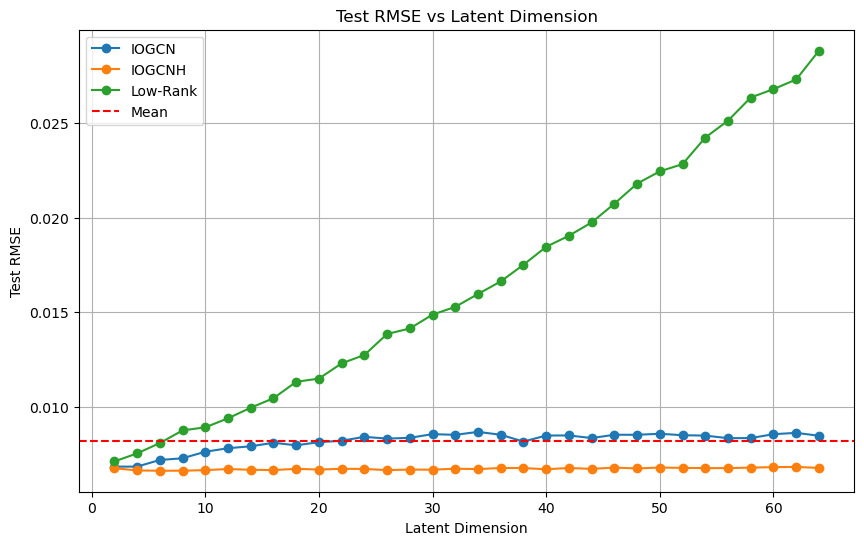

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(lat_dim_vals, rmse_iogcn_lat_dim, label='IOGCN', marker='o')
plt.plot(lat_dim_vals, rmse_iogcnh_lat_dim, label='IOGCNH', marker='o')
plt.plot(lat_dim_vals, rmse_low_rank_lat_dim, label='Low-Rank', marker='o')
plt.axhline(y=rmse_mean.item(), color='r', linestyle='--', label='Mean')
plt.xlabel('Latent Dimension')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs Latent Dimension')
plt.legend()
plt.grid()

In [135]:
with open('config_recommendation.yaml', 'r') as f:
    hyperparams = yaml.safe_load(f)

In [ ]:
datasets = ["ml-100k", "ml-1m"]#, "ml-10m"]

results_list = []
for dataset_name in datasets:
    dataset = MovieLensDataset(name=dataset_name, valid_ratio=0.1, test_ratio=0.1)
    g = dataset[0]
    Nu = g.num_nodes(ntype='user')
    Ni = g.num_nodes(ntype='movie')
    Ne = g.num_edges(etype='user-movie')

    rate = g.edges['user-movie'].data['rate']
    mean_rate = rate.mean()
    rate_norm = rate.float() - mean_rate

    user_movie_edges = g.edges(etype='user-movie')
    train_mask = g.edges['user-movie'].data['train_mask']
    val_mask = g.edges['user-movie'].data['valid_mask']
    test_mask = g.edges['user-movie'].data['test_mask']

    train_mask_mat = torch.zeros(Nu, Ni, dtype=torch.bool)
    val_mask_mat = torch.zeros(Nu, Ni, dtype=torch.bool)
    test_mask_mat = torch.zeros(Nu, Ni, dtype=torch.bool)
    rate_mat = torch.zeros(Nu, Ni)
    for j in range(Ne):
        u, i = user_movie_edges[0][j], user_movie_edges[1][j]
        rate_mat[u, i] = rate_norm[j]
        train_mask_mat[u, i] = train_mask[j]
        val_mask_mat[u, i] = val_mask[j]
        test_mask_mat[u, i] = test_mask[j]

    test_ratings = rate_mat[test_mask_mat].clone().to(device)

    if feat_type == "ratings":
        # Use ratings as features
        X = rate_mat.clone().float()
        Y = rate_mat.T.clone().float()
        X[~train_mask_mat] = 0.
        Y[~train_mask_mat.T] = 0.
    elif feat_type == "data":
        X = g.nodes["user"].data["feat"]
        Y = g.nodes["movie"].data["feat"]

    rate_mat = rate_mat.to(device)
    train_mask_mat = train_mask_mat.to(device)
    val_mask_mat = val_mask_mat.to(device)
    test_mask_mat = test_mask_mat.to(device)
    X = X.to(device)
    Y = Y.to(device)
    in_dim_x = X.shape[1]
    in_dim_y = Y.shape[1]

    results = {}

    for m, model_name in enumerate(["IOGCN", "IOGAT", "IOMLP", "IOGCNH", "low_rank", "nuclear_lr"]):
        # if dataset_name == "ml-1m" and model_name == "nuclear_lr":
        #     results[model_name] = {
        #         'RMSE': 1e4,
        #         'Best Test Loss': 1e4,
        #         'Elapsed Time': 1e4
        #     }
        #     continue
        t_start = time.time()
        print(f"Running {model_name} on {dataset_name} dataset", end=" ")

        lr = hyperparams[dataset_name][model_name]['lr']

        try:

            if model_name in ["IOGCN", "IOGAT", "IOMLP", "IOGCNH"]:
                
                if model_name in ["IOGCN", "IOGAT", "IOGCNH"]:
                    adj_type = hyperparams[dataset_name][model_name]['adj_type']
                    gmethod = hyperparams[dataset_name][model_name]['gmethod']
                    nneigh = hyperparams[dataset_name][model_name]['nneigh']
                    weighted = hyperparams[dataset_name][model_name]['weighted']
                    pct_conn = hyperparams[dataset_name][model_name]['pct_conn']
    
                    user_adj, item_adj, guser, gitem = build_graphs(adj_type, gmethod, nneigh=nneigh, weighted=weighted, pct_conn=pct_conn)
                    guser = guser.to(device).add_self_loop()
                    gitem = gitem.to(device).add_self_loop()
                else:
                    guser = None
                    gitem = None
    
                hid_dim = hyperparams[dataset_name][model_name]['hid_dim']
                out_dim = hyperparams[dataset_name][model_name]['out_dim']
                n_layers = hyperparams[dataset_name][model_name]['n_layers']
                nonlin = hyperparams[dataset_name][model_name]['nonlin']
    
                if model_name in ["IOGCN", "IOMLP"]:
                    model = eval(model_name)(in_dim_x, in_dim_y, hid_dim, out_dim, Nu, Ni, n_layers, nonlin).to(device)
                elif model_name == "IOGAT":
                    num_heads = hyperparams[dataset_name][model_name]['num_heads']
                    feat_drop = hyperparams[dataset_name][model_name]['feat_drop']
                    attn_drop = hyperparams[dataset_name][model_name]['attn_drop']
                    model = IOGAT(in_dim_x, in_dim_y, hid_dim, out_dim, Nu, Ni, n_layers, nonlin, num_heads, feat_drop, attn_drop).to(device)
                elif model_name == "IOGCNH":
                    K = hyperparams[dataset_name][model_name]['K']
                    Su = user_adj.to(device)
                    Si = item_adj.to(device)
                    model = IOGCNH(Su, Si, in_dim_x, in_dim_y, hid_dim, out_dim, Nu, Ni, n_layers, nonlin, K=K).to(device)
    
                model, best_test_loss = test(model, guser, gitem, X, Y, rate_mat,
                                             train_mask_mat, val_mask_mat, test_mask_mat,
                                             n_epochs, patience_es, lr, wd, eval_freq, verbose=False)
                est_ratings = model.get_ratings(guser, gitem, X, Y)
    
            elif model_name == "low_rank":
                rank = hyperparams[dataset_name][model_name]['rank']
                est_ratings, best_test_loss = low_rank_matrix_completion(
                    rate_mat, rank,
                    train_mask_mat, val_mask_mat, test_mask_mat,
                    lr=lr, epochs=n_epochs, patience=patience_es, verbose=False
                )
            elif model_name == "nuclear_lr":
                est_ratings, best_test_loss = nuclear_norm_matrix_completion(
                    rate_mat,
                    train_mask_mat, val_mask_mat, test_mask_mat,
                    lr=lr, epochs=n_epochs, patience=patience_es, verbose=False
                )
        except (torch.cuda.OutOfMemoryError, dgl.DGLError):
            results[model_name] = {
                'RMSE': -1.,
                'Best Test Loss': -1.,
                'Elapsed Time': -1.
            }
            continue
        est_ratings = est_ratings[test_mask_mat]
        elapsed_time = time.time() - t_start
        
        rmse = torch.sqrt(((est_ratings - test_ratings)**2).sum() / test_mask_mat.sum())

        results[model_name] = {
            'RMSE': rmse.item(),
            'Best Test Loss': best_test_loss,
            'Elapsed Time': elapsed_time
        }
        print("DONE", flush=True)
    results_list.append(results)

/home/vtenorio/.local/lib/python3.12/site-packages/dgl/data/movielens.py:201: DGLWarning: test_ratio (0.1) is not set to None for ml-100k. Note that dataset split would not be affected by the test_ratio since testing samples of ml-100k have been pre-specified.
  dgl_warning(


Running IOGCN on ml-100k dataset DONE
Running IOGAT on ml-100k dataset DONE
Running IOMLP on ml-100k dataset DONE
Running IOGCNH on ml-100k dataset DONE
Running low_rank on ml-100k dataset DONE
Running nuclear_lr on ml-100k dataset 

In [96]:
data_stats = []
datasets = ["ml-100k", "ml-1m"]
datasets_long = ['MovieLens-100k', 'MovieLens-1M']
for dataset_name in datasets:
    dataset = MovieLensDataset(name=dataset_name, valid_ratio=0.1, test_ratio=0.1)
    g = dataset[0]
    Nu = g.num_nodes(ntype='user')
    Ni = g.num_nodes(ntype='movie')
    Ne = g.num_edges(etype='user-movie')
    
    data_stats.append({
        'Nusers': Nu,
        'Nitems': Ni,
        'Nedges': Ne
    })

/home/vtenorio/.local/lib/python3.12/site-packages/dgl/data/movielens.py:201: DGLWarning: test_ratio (0.1) is not set to None for ml-100k. Note that dataset split would not be affected by the test_ratio since testing samples of ml-100k have been pre-specified.
  dgl_warning(


In [105]:
data_stats_df = pd.DataFrame(data_stats, index=datasets_long).T
data_stats_df

,MovieLens-100k,MovieLens-1M
Nusers,943,6040
Nitems,1682,3706
Nedges,100000,1000209


In [131]:
test_losses = [{k: v['Best Test Loss'] for k, v in el.items()} for el in results_list]

test_losses_df = pd.DataFrame(test_losses, index=datasets_long).T
pd.concat([data_stats_df, test_losses_df]).style.highlight_min(color='blue')

,MovieLens-100k,MovieLens-1M
Nusers,943.000000,6040.000000
Nitems,1682.000000,3706.000000
Nedges,100000.000000,1000209.000000
IOGCN,0.928731,0.761836
IOGAT,0.877631,0.759044
IOMLP,0.892243,0.744401
IOGCNH,0.868242,0.729586
low_rank,1.168850,0.782104
nuclear_lr,1.034858,0.829523


In [132]:
rmses = [{k: v['RMSE'] for k, v in el.items()} for el in results_list]

rmses_df = pd.DataFrame(rmses, index=datasets_long).T
pd.concat([data_stats_df, rmses_df]).style.highlight_min(color='blue')

,MovieLens-100k,MovieLens-1M
Nusers,943.000000,6040.000000
Nitems,1682.000000,3706.000000
Nedges,100000.000000,1000209.000000
IOGCN,0.963707,0.872832
IOGAT,0.936820,0.871231
IOMLP,0.944586,0.862786
IOGCNH,0.931795,0.854158
low_rank,1.081134,0.884366
nuclear_lr,1.017280,0.910781


In [133]:
times = [{k: v['Elapsed Time'] for k, v in el.items()} for el in results_list]

times_df = pd.DataFrame(times, index=datasets_long).T
pd.concat([data_stats_df, times_df]).style.highlight_min(color='blue')

,MovieLens-100k,MovieLens-1M
Nusers,943.000000,6040.000000
Nitems,1682.000000,3706.000000
Nedges,100000.000000,1000209.000000
IOGCN,25.815317,112.404729
IOGAT,42.557813,39.876104
IOMLP,9.438913,33.495577
IOGCNH,18.467719,279.145848
low_rank,4.212021,7.308576
nuclear_lr,142.064090,22590.233299


In [134]:
import pandas as pd

# Assuming `data_stats_df`, `rmses_df`, and `times_df` are already defined in the notebook
datasets_long = ['MovieLens-100k', 'MovieLens-1M']

# Update model names for better readability
rmses_df = rmses_df.rename(index={"low_rank": "MF", "nuclear_lr": "LR Nuc"})
times_df = times_df.rename(index={"low_rank": "MF", "nuclear_lr": "LR Nuc"})

# Define the new order of models
model_order = ["IOGAT", "IOGCNH", "IOMLP", "MF", "LR Nuc"]

# Generate LaTeX table
latex_table = r"""
\begin{table*}[ht]
\renewcommand{\tabcolsep}{3pt}
\centering
\caption{Performance comparison of models across datasets.}
\begin{tabular}{lcccc""" + "cc" * len(model_order) + r"""}
\toprule
\multirow{2}{*}{\textbf{Dataset}} & \multirow{2}{*}{\boldmath{$N_u$}} & \multirow{2}{*}{\boldmath{$N_i$}} & \multirow{2}{*}{\boldmath{$N_r$}}"""

# Add model names as multicolumn headers
for model in model_order:
    latex_table += f" & \\multicolumn{{2}}{{c}}{{\\textbf{{{model}}}}}"

latex_table += r""" \\
\cmidrule(r){5-6} \cmidrule(r){7-8} \cmidrule(r){9-10} \cmidrule(r){11-12} \cmidrule(r){13-14}
& & & """ + " & RMSE & Time" * len(model_order) + r""" \\
\midrule
"""

# Add rows for each dataset
for dataset in datasets_long:
    latex_table += f"{dataset} & {data_stats_df.loc['Nusers', dataset]} & {data_stats_df.loc['Nitems', dataset]} & {data_stats_df.loc['Nedges', dataset]}"
    for model in model_order:
        latex_table += f" & {rmses_df.loc[model, dataset]:.6f} & {times_df.loc[model, dataset]:.2f}"
    latex_table += r" \\" + "\n"

latex_table += r"""
\bottomrule
\end{tabular}
\label{tab:recommendation}
\end{table*}
"""

# Print the LaTeX table
print(latex_table)


\begin{table*}[ht]
\renewcommand{\tabcolsep}{3pt}
\centering
\caption{Performance comparison of models across datasets.}
\begin{tabular}{lcccccccccccccc}
\toprule
\multirow{2}{*}{\textbf{Dataset}} & \multirow{2}{*}{\boldmath{$N_u$}} & \multirow{2}{*}{\boldmath{$N_i$}} & \multirow{2}{*}{\boldmath{$N_r$}} & \multicolumn{2}{c}{\textbf{IOGAT}} & \multicolumn{2}{c}{\textbf{IOGCNH}} & \multicolumn{2}{c}{\textbf{IOMLP}} & \multicolumn{2}{c}{\textbf{MF}} & \multicolumn{2}{c}{\textbf{LR Nuc}} \\
\cmidrule(r){5-6} \cmidrule(r){7-8} \cmidrule(r){9-10} \cmidrule(r){11-12} \cmidrule(r){13-14}
& & &  & RMSE & Time & RMSE & Time & RMSE & Time & RMSE & Time & RMSE & Time \\
\midrule
MovieLens-100k & 943 & 1682 & 100000 & 0.936820 & 42.56 & 0.931795 & 18.47 & 0.944586 & 9.44 & 1.081134 & 4.21 & 1.017280 & 142.06 \\
MovieLens-1M & 6040 & 3706 & 1000209 & 0.871231 & 39.88 & 0.854158 & 279.15 & 0.862786 & 33.50 & 0.884366 & 7.31 & 0.910781 & 22590.23 \\

\bottomrule
\end{tabular}
\label{tab:recommendatio

<AxesSubplot: >

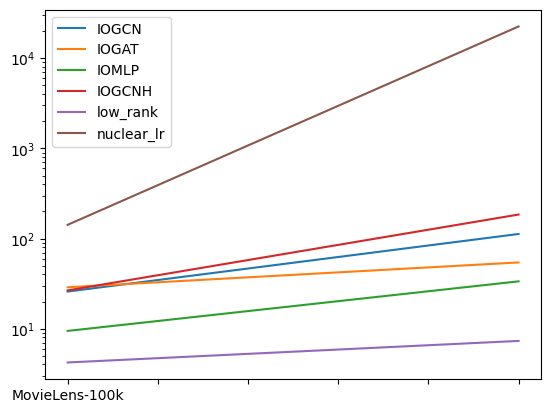

In [74]:
times_df.T.plot(logy=True)

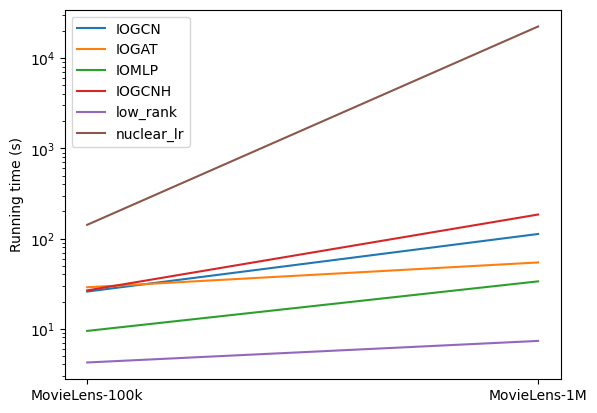

In [75]:
plt.semilogy(np.arange(2), times_df.values.T)
plt.xticks(np.arange(2), datasets_long)
plt.ylabel("Running time (s)")
plt.legend(times_df.index)

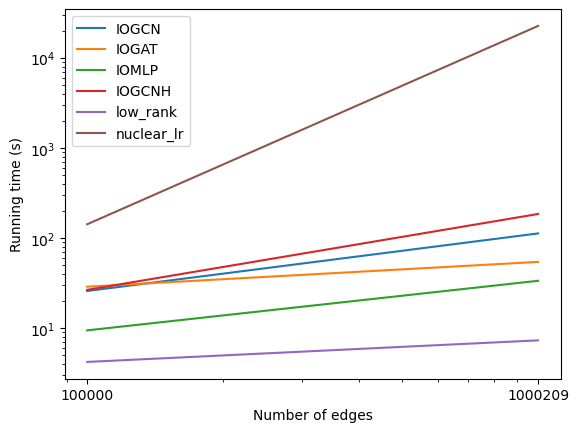

In [76]:
nedges_arr = np.array([el['Nedges'] for el in data_stats])
plt.loglog(nedges_arr, times_df.values.T)
plt.xticks(nedges_arr, nedges_arr)
plt.ylabel("Running time (s)")
plt.xlabel("Number of edges")
plt.legend(times_df.index)